# Metadata
---

- Created: 2022-09-01
- Last modified: 2022-09-01
- Author: Daniel Kaiser
- Project Identifiers: EMB_ex03
- Last read and understood by: ???
- Changelog:
    - (2022-09-01) Initialized notebook
    - (2022-09-01) Adjusted notebook organization
    - (2022-09-01) Added Mercator embeddings, approximation of hyperbolic distance
    - (2022-09-01) Ran v1.1

# Preface
---

## Experiment protocol

<!-- Yes, I know the &nbsp is annoying, tabs are automatically removed in basic markdown ok -->
<u>**Experiment ID and project**</u>

EMB_ex03

<u>**Date designed and version**</u>

- 2022-09-01v1.0
- 2022-09-01v1.1

<u>**Date conducted**</u>

- 2022-09-01v1.1

<u>**Researcher(s)**</u>

Daniel Kaiser

<u>**Description**</u>

**Purpose**

This experiment is designed to explore the accuracy of multiplex reconstruction utilizing Euclidean distance as a proxy for the likelihood of edge-layer placement. Embedding the "remnant" of each layer of a XOR-aggregated duplex (scale-free layers, configurable edge correlation), an edge to be classified from the aggregate is predicted to originate from the layer whose remnant embedding yields a smaller distance of the edge endpoints.

**Hypothesis (if applicable)**

The expected outcome of this experiment is an AUROC curve of classification that is an increasing function of PFI, decreasing function of degree homogeneity and edge correlation. Note this matches the high-level qualitative results of the naive Bayes approach used in earlier work. (Project identifier "MEC")

<u>**Data & Code**</u>

**Prerequisite data (if applicable)**

This experiment measures AUROC on synthetic, configurable scale-free duplexes. The layers of the duplex are generated according to `Utils.py:generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)`. The configurable parameters are:

- N; number of nodes (forced exact node overlap in layers)
- gamma; scale-free parameter of degree distribution
- kmin; enforced minimum node degree
- kmax; enforced maximum node degree (structural cut-off)
- prob; probability any given node degree is swapped with another random node's degree from layer $\alpha$. Applied to all of $\alpha$, samples the other layer of duplex, $\beta$.
- sign; controls the sorting before degree re-assignment procedure. -1 corresponds to anti-correlation, 1 to correlation
    - prob=0, sign=-1 is perfectly anti-correlated degree sequences
    - prob=0, sign=1 is perfectly correlated degree sequences (exact same!)
    - prob=1, sign=-1 or 1 are two random draws from same degree distribution (characterized by $\gamma$)


**Resultant data**

The resultant data is in the form of a dataframe with columns:
- N
- gamma
- kmin
- prob
- sign
- pfi
- Accuracy
- dimensions
- walk_length
- num_walks
- workers
- window
- min_count
- batch_words

Optionally, the node embeddings for each layer of the duplexes associated to each of these dataframe records can be saved as well. They should be saved as pickled numpy arrays of size (N, dimensions).

**Code**

This experiment relies on the script `Utils.py` or functions in this document. All code from `Utils.py` is original or only slightly modified MEC code from @Filippo Radicchi.

@Elior Cohen and node2vec's [GitHub repo](https://github.com/eliorc/node2vec) inspired the function `embed_system`.

Some package version updates in Gensim forced some adjustments - thanks to @555wen on [this StackExchange post](https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size) from @yinky for pointing out a parameter name change. In the site-packages for node2vec, `node2vec.py:175` was altered from `if 'size' not in skip_gram_params:` to `if 'vector_size' not in skip_gram_params:`and `node2vec.py:176` was altered from `skip_gram_params['size'] = self.dimensions` to `skip_gram_params['vector_size'] = self.dimensions`.

<u>**Procedure**</u>

The following procedure was conducted to run this experiment and is sufficient to replicate the workflow along with code described in the "Code" section above.
1. Generate duplex, $\mathcal{M} = (V, (\alpha, \beta))$
2. Aggregate duplex into a monoplex, $G$, and observe some partial information for each layer $\mathcal{O}_{\alpha}, \mathcal{O}_{\beta}$
3. Create remnants by $\mathcal{R}_{\alpha} = G \setminus \mathcal{O}_{\alpha}, \mathcal{R}_{\beta} = G \setminus \mathcal{O}_{\beta}$
4. Embed $\mathcal{R}_{\alpha}, \mathcal{R}_{\beta}$ separately using node2vec. Call the resultant embedded points $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$.
5. Apply 2-component principal component analysis to $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$ to project into $\mathbb{R}^2$. Retain the same names as we will not use the higher dimension vectors at all past this point.
5. For $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$, classify $(i,j)$ as having originated from layer
$$
\hat{l}_{ij} = \text{argmin}_{\gamma \in \{\alpha, \beta \}} \| \mathcal{D}_{\gamma}(i) - \mathcal{D}_{\gamma}(j) \|
$$
6. Calling the true originating layer of $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$ as $l_{ij}$, measure $\| l - \hat{l} \|$
    - NOTE: Since this is a binary classification problem, we actually elect to use the AUROC of the classification of $(i,j) \mapsto \hat{l}_{ij}$ with ground truth $l_{ij}$. The vector norm is simply a more general form of measuring "difference" in our classifications and the ground truth.

## Theoretical foundations and symbol/prior result guide

Will eventually ill in with background from project "MEC" but I am being lazy tbh...

# Experiment
---

## Setup

### Imports

In [1]:
# --- Standard library ---
import sys  # System pathing
import yaml  # Configuration files
from datetime import datetime  # Timestamping data
from copy import deepcopy  # Parameter grid processing
from itertools import product

# --- Scientific ---
import numpy as np  # General computational tools
from sklearn import metrics, decomposition  # Measuring classifier performance

# --- Network science ---
import networkx as nx  # General network tools
from node2vec import Node2Vec as N2V  # Embedding tools

# --- Project source code ---
sys.path.append("../src/")
from Utils import *  # Custom synthetic benchmarks
import mercator  # Mercator code (see bin)


# --- Data handling and visualization ---
import pandas as pd  # Dataframe tools
from tabulate import tabulate  # Pretty printing for dataframes

import seaborn as sns  # Easier plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# --- Miscellaneous ---
from tqdm.auto import tqdm  # Progress bar

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'wurlitzer', 'infomap', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'wurlitzer', 'infomap'}


### Globals

In [2]:
# --- Other import aliases ---
today = datetime.today
accuracy = metrics.accuracy_score
auroc = metrics.roc_auc_score
PCA = decomposition.PCA

# --- Visualization ---
rc_dict = {
#   "savefig.dpi": 600,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
#   "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)

### Configuration

In [3]:
# Processing configuration file
config_ = "../workflow/configs/debug-mercator.yaml"
with open(config_, 'r') as _fh:
    config = yaml.safe_load(_fh)

# --- Convenience aliasing ---
datafiles_ = config["workflow"]["datafiles"]
pathing_ = config["workflow"]["pathing"]
versioning_ = config["workflow"]["versioning"]

# - Pathing -
tmp = pathing_["TMP"]
raw = pathing_["RAW"]
processed = pathing_["PROCESSED"]
figures = pathing_["FIGURES"]

# - Versioning -
project_id = versioning_["project_id"]
current_version = versioning_["current_version"]
researcher = versioning_["researcher"]
date = today().strftime("%Y%m%d")

# - Datafiles -
save_ = datafiles_["KEEP_EMBEDDINGS"]
template_df = datafiles_["TEMPLATE_DF"].format(project_id=project_id, current_version=current_version, researcher=researcher, date=date)
template_vectors = datafiles_["TEMPLATE_VECTORS"]

### Functions

In [4]:
def form_system(params):
    # Process parameters
    N, gamma, kmin, prob, sign = params["N"], params["gamma"], params["kmin"], params["prob"], params["sign"]
    pfi = params["pfi"]
    kmax = np.sqrt(N)

    # Form "raw" duplex
    D = generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)

    # Split into layers
    G, H = duplex_network(D, 1, 2)

    # Observe partial information
    R_G, R_H, agg = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        R_G_.add_edges_from(R_G.subgraph(maxcc_R_G).edges())
        R_H_.add_edges_from(R_H.subgraph(maxcc_R_H).edges())

        agg = set(R_G_.edges()) | set(R_H_.edges())
    else:
        agg = set(agg.keys())

    return G, H, R_G, R_H, agg

def embed_system(R_G, R_H, params):
    # Save temporary edge lists
    # ! NOTE: Not parallelizable, mixed IO streams
    _fh_R_G = tmp + "G.edgelist"
    _fh_R_H = tmp + "H.edgelist"
    nx.write_edgelist(R_G, _fh_R_G)
    nx.write_edgelist(R_H, _fh_R_H)

    # Embed on edgelists
    _fh_E_G = template_vectors.format(tmp, "mercator-original", params["N"], params["gamma"], params["kmin"], params["prob"], params["sign"], params["pfi"], params["repetition"])
    _fh_E_H = template_vectors.format(tmp, "mercator-shuffled", params["N"], params["gamma"], params["kmin"], params["prob"], params["sign"], params["pfi"], params["repetition"])
    mercator.embed(_fh_R_G, output_name=_fh_E_G)
    mercator.embed(_fh_R_G, output_name=_fh_E_H)
    _fh_E_G = _fh_E_G + ".inf_coord"
    _fh_E_H = _fh_E_H + ".inf_coord"

    # Load vectors from file
    E_G = np.loadtxt(_fh_E_G, usecols=(2,3))
    E_H = np.loadtxt(_fh_E_H, usecols=(2,3))

    return E_G, E_H

def reduce_dimension(E_G, E_H, n_components=2):
        pca = PCA(n_components=n_components)
        E_G = pca.fit_transform(E_G)

        pca = PCA(n_components=n_components)
        E_H = pca.fit_transform(E_H)

        return E_G, E_H

def reconstruct_system(G, H, agg, E_G, E_H):
    cls = []
    scores = []
    gt = []
    for i, j in agg:
        if (i, j) in G.edges():
            gt.append(1)
        else:
            gt.append(0)

        i_G_theta, i_G_radius = E_G[i, [0,1]]
        j_G_theta, j_G_radius = E_G[j, [0,1]]
        i_H_theta, i_H_radius = E_H[i, [0,1]]
        j_H_theta, j_H_radius = E_H[j, [0,1]]

        # * NOTE: Can approximate hyperbolic distance by x_{ij} = r_i + r_j + 2 ln (Delta Theta_ij / 2)
        d_G = i_G_radius + j_G_radius + 2*np.log(abs(i_G_theta - j_G_theta) / 2)
        d_H = i_H_radius + j_H_radius + 2*np.log(abs(i_H_theta - j_H_theta) / 2)

        # d_G = 1 / d_G
        # d_H = 1 / d_H
        d_G = np.exp(-d_G)
        d_H = np.exp(-d_H)

        t_G = d_G / (d_G + d_H)
        t_H = 1 - d_H

        scores.append(t_G)

        if t_G > t_H:
            cls.append(1)
        elif t_H > t_G:
            cls.append(0)
        else:
            cls.append(np.random.randint(2))

    return cls, scores, gt

def measure_performance(cls, scores, gt):
    acc = accuracy(gt, cls)
    auc = auroc(gt, scores)

    return acc, auc

### Workflow

In [5]:
def _process_grid(config):
    # Process parameter grid
    grid = []

    params = {}
    # params.update(config["embedding"])

    network_ = config["network"]
    network_grid_ = product(*network_.values())
    for (N, gamma, kmin, prob, sign, pfi, repetition, largest_component) in network_grid_:
        params_ = deepcopy(params)
        params_["N"] = N
        params_["gamma"] = gamma
        params_["kmin"] = kmin
        params_["prob"] = prob
        params_["sign"] = sign
        params_["pfi"] = pfi
        params_["repetition"] = repetition
        params_["largest_component"] = largest_component
        grid.append(params_)

    return grid

def workflow(config, save_df=True):
    # Process parameter grid
    grid = _process_grid(config)

    # Prepare results dataframe (dict)
    df_ = {key: [] for key in grid[0].keys()}
    df_["Accuracy"] = []
    df_["AUROC"] = []

    # Run experiment
    for gv in tqdm(grid):
        # Track parameters
        for key, value in gv.items():
            df_[key].append(value)

        # Generate synthetic system and form remnants
        G, H, R_G, R_H, agg = form_system(gv)

        # Apply mercator
        G_, H_ = embed_system(R_G, R_H, gv)

        # Apply PCA
        G_, H_ = reduce_dimension(G_, H_)

        # Reconstruct system from embeddings
        cls, scores, gt = reconstruct_system(G, H, agg, G_, H_)

        # Measure performance
        acc, auc = measure_performance(cls, scores, gt)

        # Update performance measure columns
        df_["Accuracy"].append(acc)
        df_["AUROC"].append(auc)

    # Format dataframe and save
    df = pd.DataFrame(df_)

    if save_df:
        df.to_csv(f"{raw}/{template_df}.csv")

    return df

## Computations

In [6]:
df = workflow(config, True)

100%|██████████| 4/4 [8:06:29<00:00, 7297.27s/it]  


In [7]:
print(tabulate(df[["gamma", "prob", "sign", "pfi", "Accuracy", "AUROC"]], headers='keys', tablefmt='psql'))

+----+---------+--------+--------+-------+------------+----------+
|    |   gamma |   prob |   sign |   pfi |   Accuracy |    AUROC |
|----+---------+--------+--------+-------+------------+----------|
|  0 |     2.1 |      0 |     -1 |  0.05 |   0.474068 | 0.496535 |
|  1 |     2.1 |      0 |     -1 |  0.33 |   0.485069 | 0.501546 |
|  2 |     2.1 |      0 |     -1 |  0.67 |   0.417748 | 0.493108 |
|  3 |     2.1 |      0 |     -1 |  0.95 |   0.292284 | 0.507344 |
+----+---------+--------+--------+-------+------------+----------+


## Debugging

### Case studies

#### "Random cases" - should be equal

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=1.0 --- sign=-1')

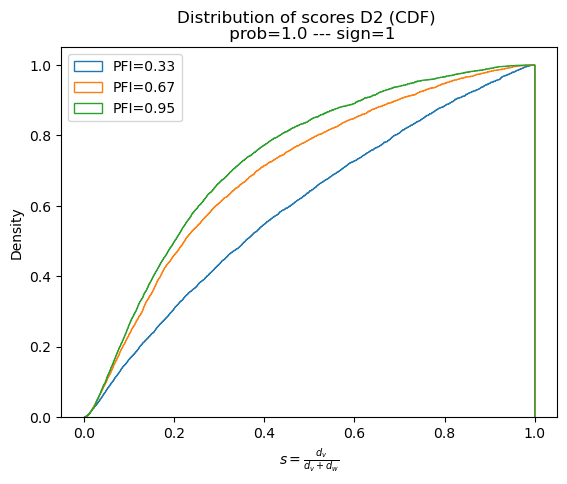

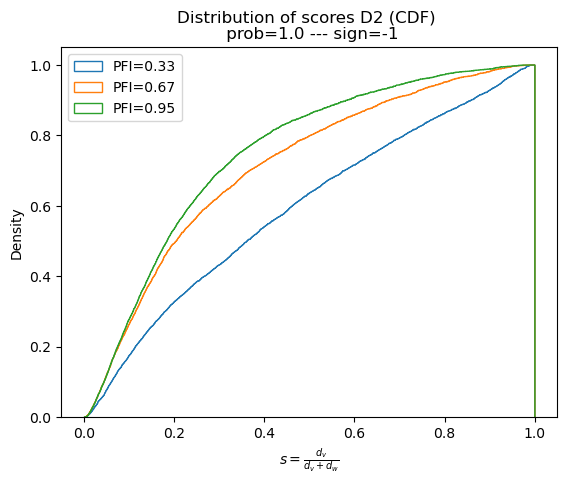

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = 1
prob = 1.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
N = 500
gamma = 2.0
kmin = 3
sign = -1
prob = 1.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")


#### "Easy cases"

Text(0.5, 1.0, 'Distribution of displacements $(d_v - d_w)$ D2 (CDF) \n pfi=0.95 --- sign=-1')

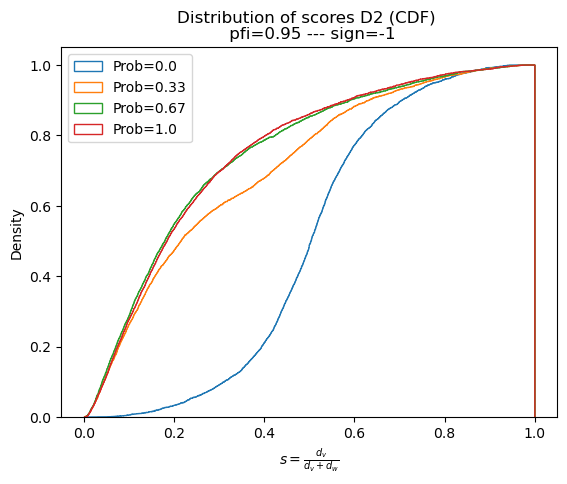

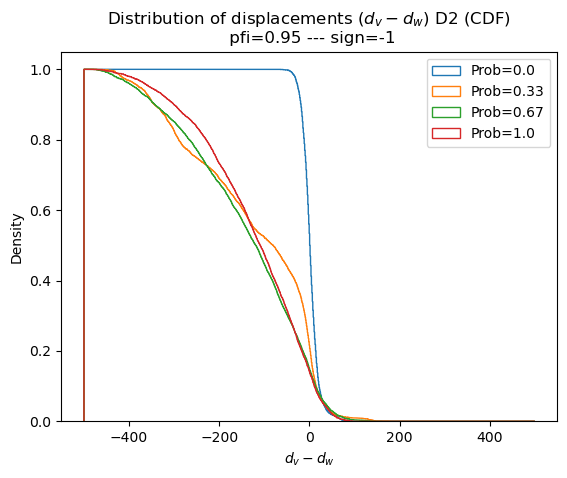

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
pfi = 0.95
repetition = 1

plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n pfi={pfi} --- sign={sign}")

# ====================================================================
plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    deltas_higher = []
    scores_higher = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

                # R^128 distance
                v_i = original[i, :]
                v_j = original[j, :]
                w_i = shuffled[i, :]
                w_j = shuffled[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores_higher.append(d_v / (d_v + d_w))
                deltas_higher.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=-1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper right")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements $(d_v - d_w)$ D2 (CDF) \n pfi={pfi} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of displacements D2 (CDF) \n prob=0.0 --- sign=-1')

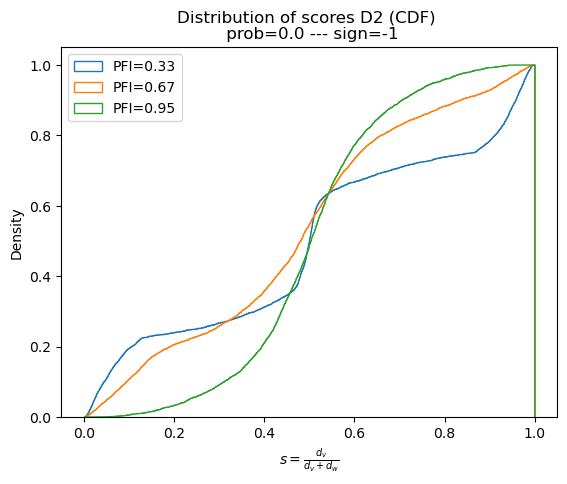

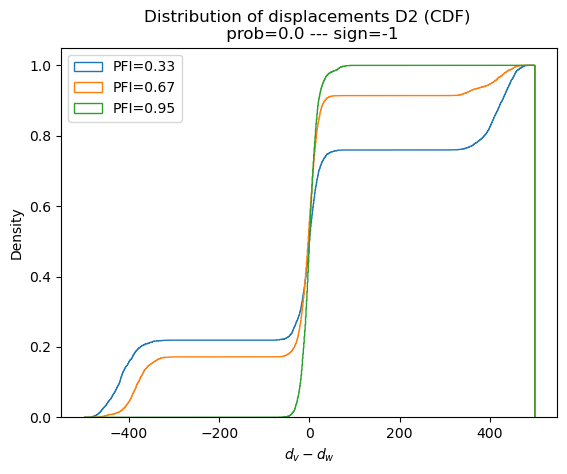

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
prob = 0.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements D2 (CDF) \n prob={prob} --- sign={sign}")

#### "Hard cases"

Text(0.5, 1.0, 'Distribution of displacements D2 (CDF) \n prob=0.0 --- sign=1')

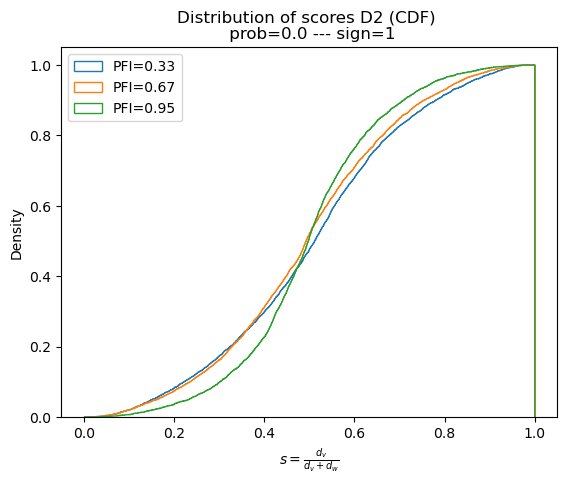

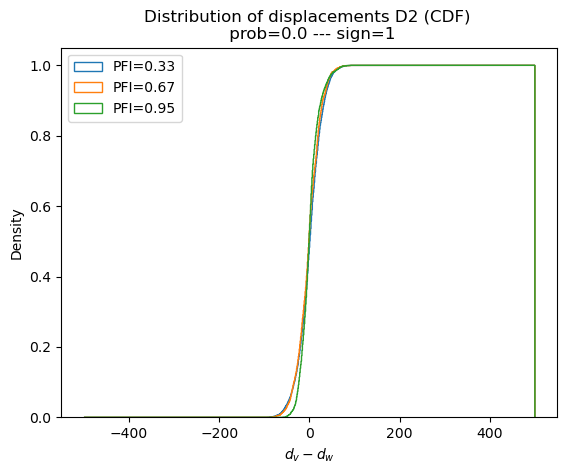

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = 1
prob = 0.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements D2 (CDF) \n prob={prob} --- sign={sign}")

### Broader pictures

#### Displacements

In the following, larger AUC correspond to more _dissimilar_ the layer embeddings are (equivalently, the smaller the AUC, the more _similar_ the layer embeddings are)

Highly dissimilar layers are easier to classify! We want a large area!

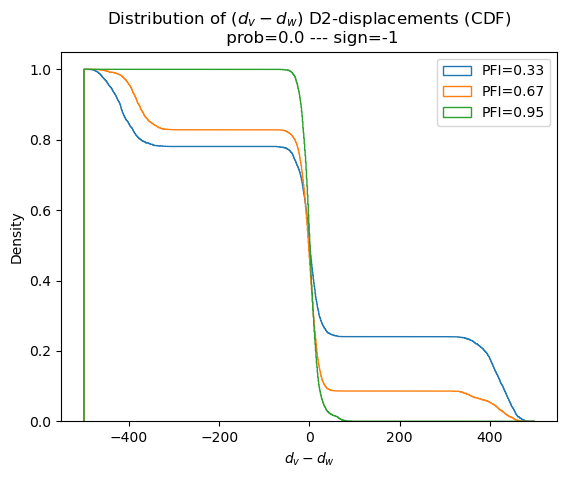

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 0.0
sign = -1
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(d_v-d_w)

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- (C)CDF ---
    plt.hist(
        deltas,
        histtype="step", cumulative=-1,
        bins=linbins, density=True,
        label=f"PFI={pfi}"
    )

    # Labels and titles
    plt.legend(loc="upper right")
    plt.xlabel("$d_v - d_w$")
    plt.ylabel("Density")
    plt.title(f"Distribution of $(d_v - d_w)$ D2-displacements (CDF)\n prob={prob} --- sign={sign}")

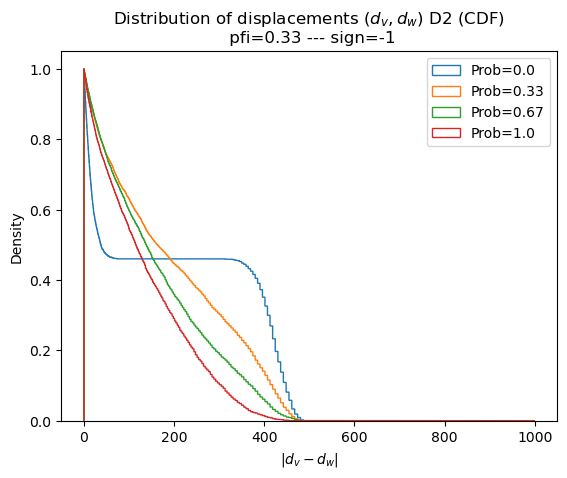

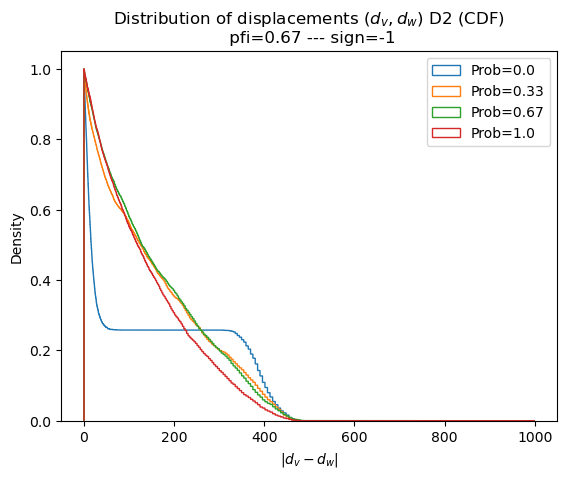

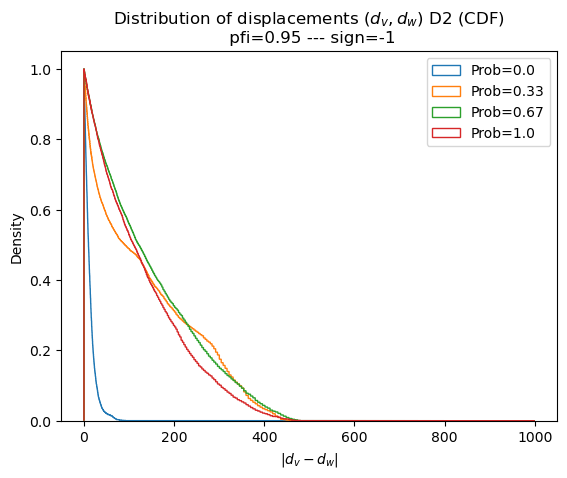

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 1.0
sign = -1
pfi = 0.33
repetition = 1

for pfi in [0.33, 0.67, 0.95]:
    plt.figure()
    for prob in [0.0, 0.33, 0.67, 1.0]:
        # ----- Loading some embeddings -----
        t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
        original = np.loadtxt(processed+"original"+t)
        shuffled = np.loadtxt(processed+"shuffled"+t)

        # ----- Applying PCA (-> R^2) -----
        pca = PCA(n_components=2)
        pca.fit(original)
        v = pca.transform(original)

        pca = PCA(n_components=2)
        pca.fit(shuffled)
        w = pca.transform(shuffled)


        # ----- Measuring distribution -----
        deltas = []
        scores = []
        deltas_higher = []
        scores_higher = []
        for i in range(100):
            for j in range(100):
                if i != j:
                    # R^2 distance
                    v_i = v[i, :]
                    v_j = v[j, :]
                    w_i = w[i, :]
                    w_j = w[j, :]

                    d_v = np.linalg.norm(v_i - v_j)
                    d_w = np.linalg.norm(w_i - w_j)

                    scores.append(d_v / (d_v + d_w))
                    deltas.append(abs(d_v-d_w))

                    # R^128 distance
                    v_i = original[i, :]
                    v_j = original[j, :]
                    w_i = shuffled[i, :]
                    w_j = shuffled[j, :]

                    d_v = np.linalg.norm(v_i - v_j)
                    d_w = np.linalg.norm(w_i - w_j)

                    scores_higher.append(d_v / (d_v + d_w))
                    deltas_higher.append(abs(d_v-d_w))

        # Plotting difference in distances
        # * NOTE: log-scale (C)CDFs
        logbins = np.logspace(-3, 3, num=1000, endpoint=True)
        linbins = np.linspace(0, 1, num=1000, endpoint=True)

        # --- CDF Scores ---
        plt.hist(
            deltas,
            histtype="step", cumulative=-1,
            bins=logbins, density=True,
            label=f"Prob={prob}",
        )


    # Labels and titles
    plt.legend(loc="upper right")
    plt.xlabel("$\| d_v - d_w \|$")
    plt.ylabel("Density")
    plt.title(f"Distribution of displacements $(d_v, d_w)$ D2 (CDF) \n pfi={pfi} --- sign={sign}")

#### Scores

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=0.0 --- sign=-1')

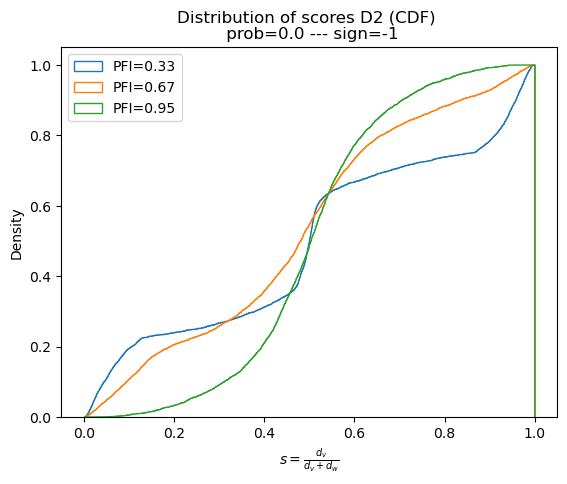

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 0.0
sign = -1
pfi = 0.33
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )

# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=1.0 --- sign=-1')

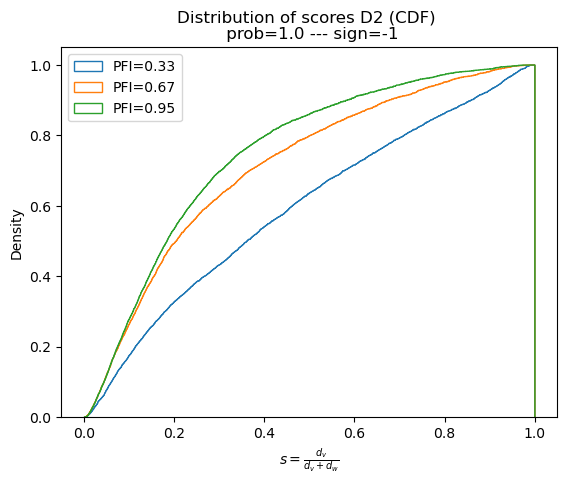

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 1.0
sign = -1
pfi = 0.33
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )

# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n pfi=0.95 --- sign=-1')

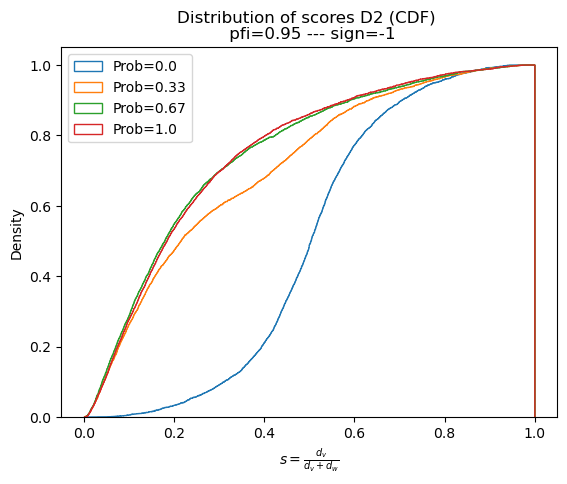

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
pfi = 0.95
repetition = 1

plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n pfi={pfi} --- sign={sign}")

# Analysis
---

## Post-processing data

In [15]:
# Uncomment and specify if loading from file instead of continuing from recently run above experiment
df = pd.read_csv(f"{raw}/EMB_ex03v1.1_DK_20220901.csv")

## Visualization

### Initial exploration

<Figure size 640x480 with 0 Axes>

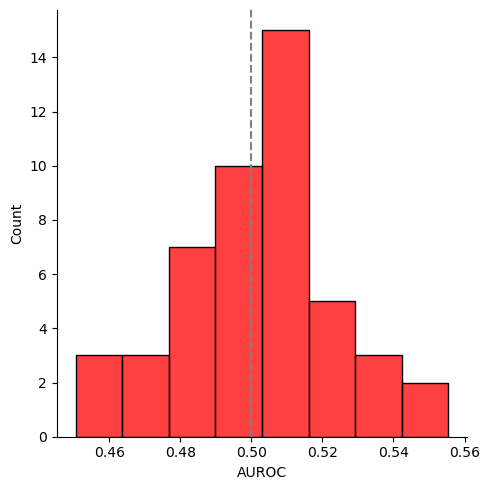

In [17]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    color="red"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

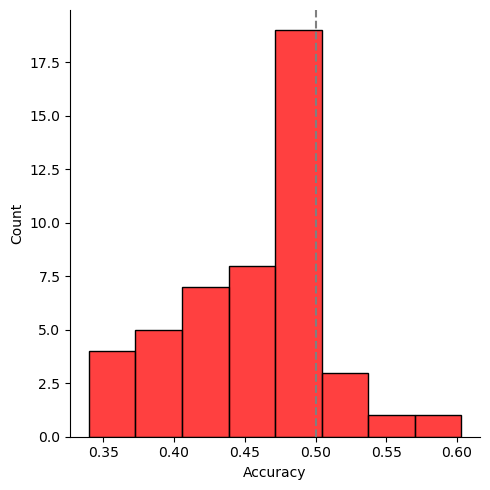

In [18]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="Accuracy",
    color="red"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_accuracy_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

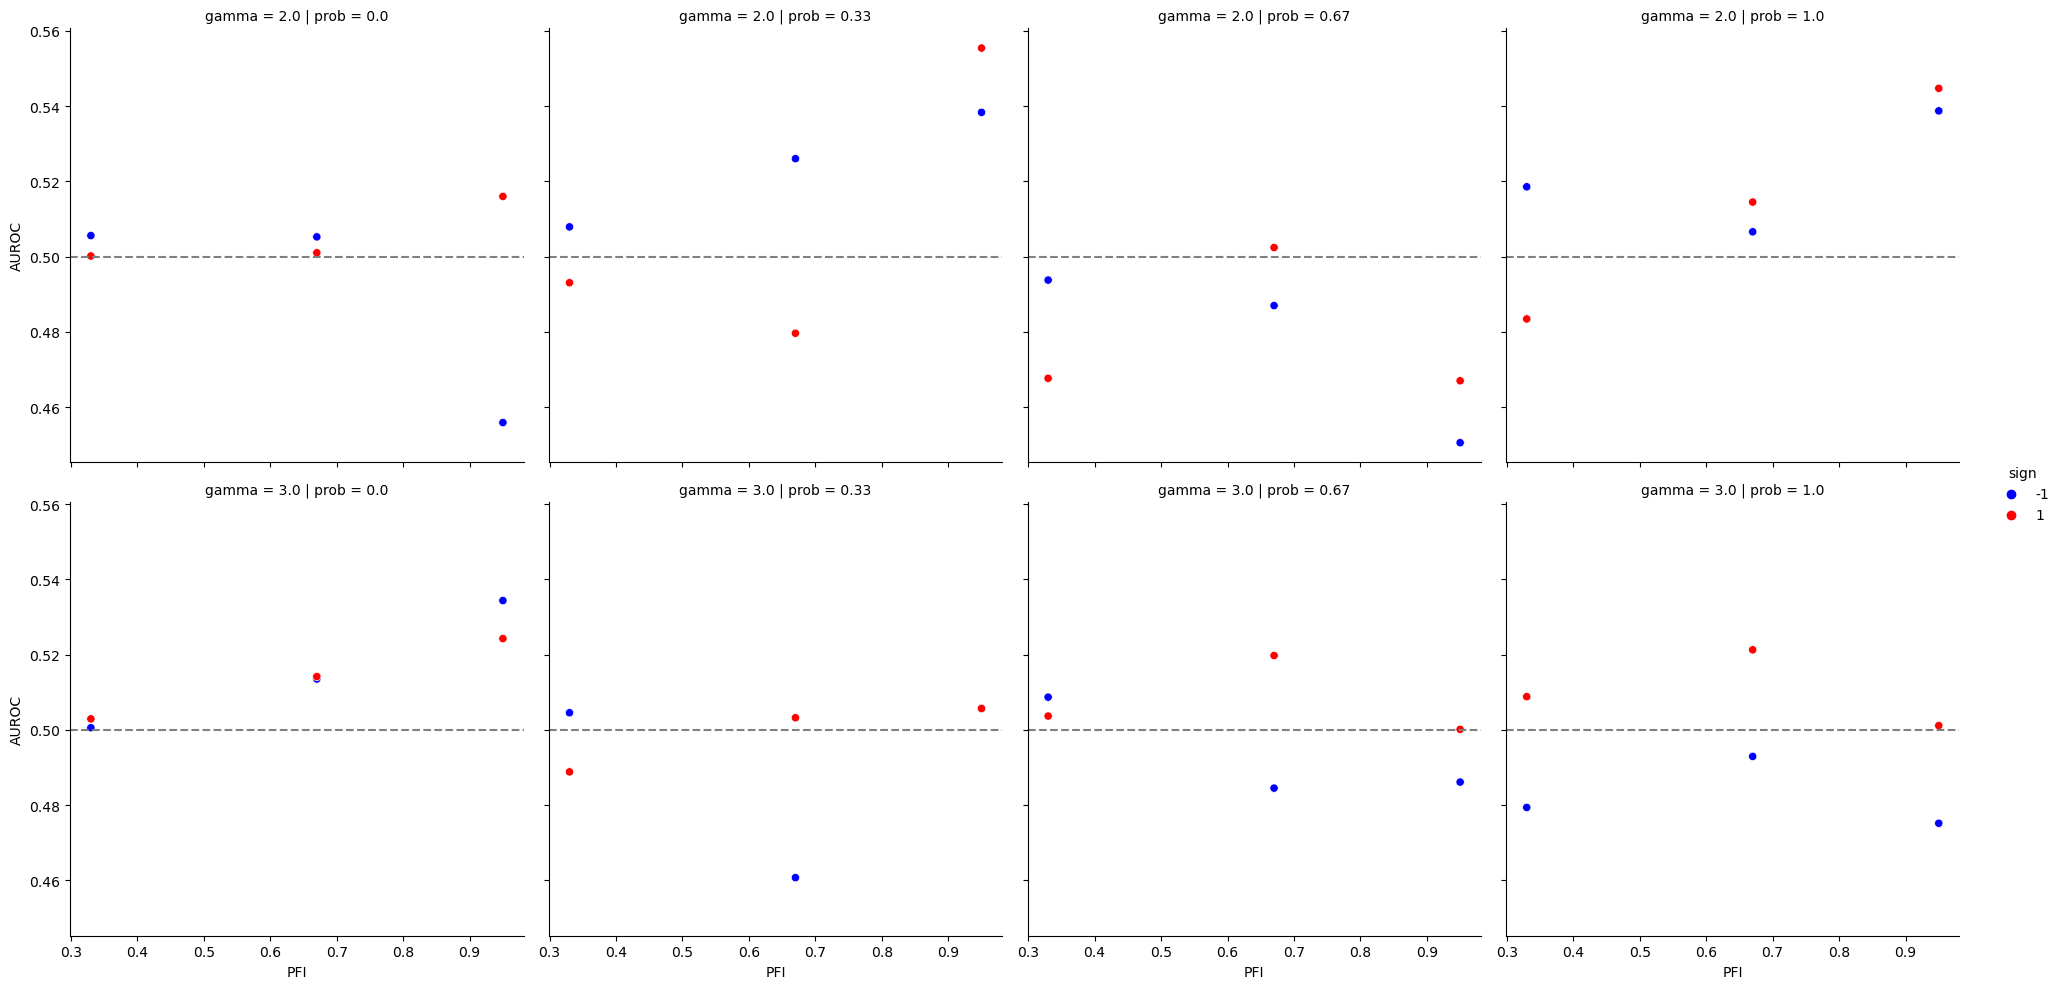

In [13]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    row="gamma",
    col="prob",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/faceted-scatter_auroc-pfi-gamma-prob-sign_{template_df}.png")
figure_

### Effect of PFI

<Figure size 640x480 with 0 Axes>

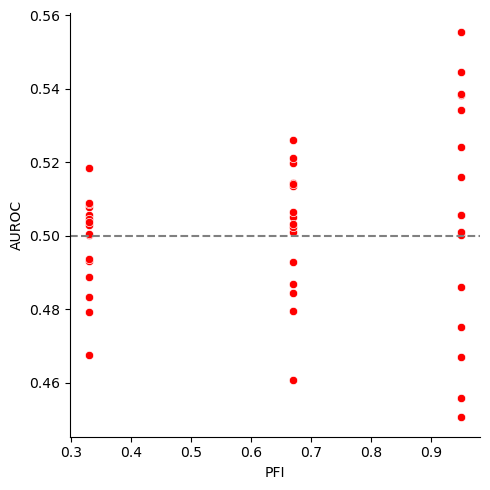

In [19]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    color="red"
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/scatter_auroc-pfi_{template_df}.png")
figure_

### Effect of degree heterogeneity ($\gamma$)

<Figure size 640x480 with 0 Axes>

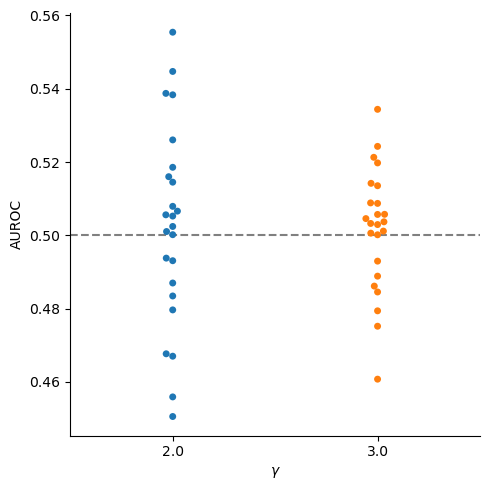

In [15]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="gamma", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("$\gamma$", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-gamma_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

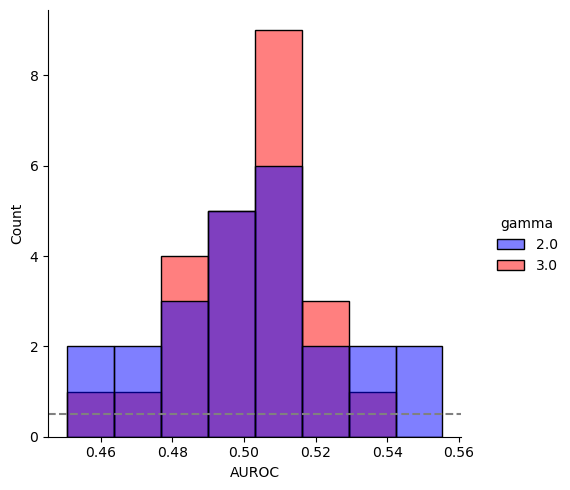

In [16]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="gamma", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-gamma_{template_df}.png")
figure_

### Effect of correlation prob

<Figure size 640x480 with 0 Axes>

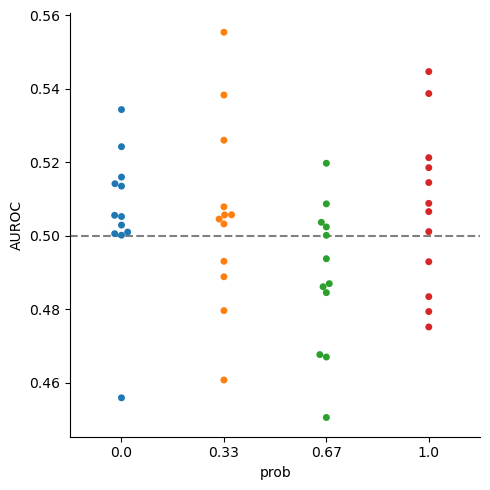

In [17]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="prob", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("prob", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-prob_{template_df}.png")
figure_

### Effect of sorting (sign)

<Figure size 640x480 with 0 Axes>

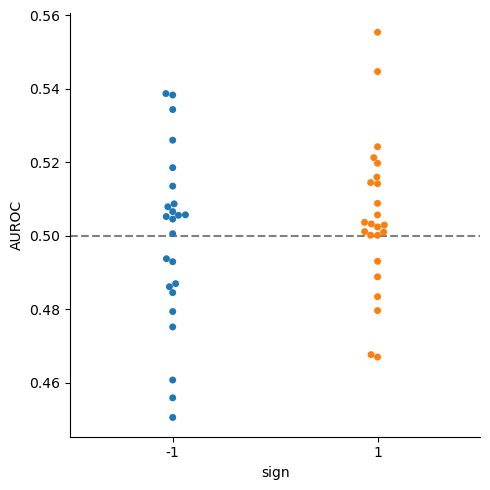

In [18]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="sign", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("sign", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-sign_{template_df}.png")
figure_

<Figure size 640x480 with 0 Axes>

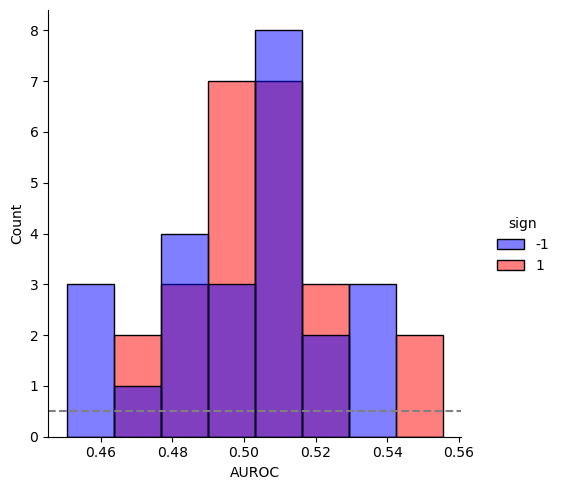

In [19]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-sign_{template_df}.png")
figure_

# Discussion
---

## Observations

Currently, the AUROC seems to be centered about 0.5 regardless of parameters.

Note that the distance approximation here is an estimate, however, so a strong clustering of scores about 0.5 may suggest misclassifications due to thresholding noise. That said, the AUROC measure should account for these things implicitly.

## Interpretations

The clear centering of $AUROC \approx 0.5$ suggests that there is no noticeable effect from the parameters of the duplex. This certainly seems nonsensical at first glance - it is no better than a random classifier (recall the layers are approximately the same size.)

[Unfinished thought] While I am still uncertain why, it is possible the encodings as they are now simply do not house the necessary information to do classifications of this type. This may be the case because the information that is _a priori_ observed of the originating duplex is ignored in the remnants (kind of). I'm also having trouble articulating this thought as of now. I will return later.

At this point (EMB_ex03v1.1) I have ruled out the following hypotheses I have had as to the poor performance:
- [Curse of dimensionality]((https://en.wikipedia.org/wiki/Curse_of_dimensionality)) (applied PCA into $\mathbb{R}^2$)
- Disconnected components confounding random walkers (After forming remnant, restricted to largest connected component)
- Euclidean embeddings insufficient (Experimented with Mercator, a projection into $\mathbb{S}^1$)

## Follow-up

Some potentital next steps would be exploring embedding hyperparameters more carefully, specifically, `walk_length` is known to have a strong effect on what structures are preserved in the embedded space (well, retrievable).

Additionally, ER networks may be a simpler model to begin with, since this appears to be giving nonsense results?

Tentative follow-up experiments:
1. node2vec, Mercator on ER duplexes
2. Sweeps over embedding hyperparameters (specifically, at least `walk_length`)
3. 